In [1]:
import numpy as np
from torch.utils.tensorboard.writer import SummaryWriter
from dataclasses import dataclass
import concurrent.futures
from collections import defaultdict
import typing
from torch import optim
import torch
import os
import random
import copy


%load_ext autoreload
%autoreload 2
import env
import network
import player
import visualize

BOARD_XSIZE = env.BOARD_XSIZE
BOARD_YSIZE = env.BOARD_YSIZE

DIMS=(BOARD_XSIZE,BOARD_YSIZE)


EPISODES_PER_AGENT = 128
TRAIN_EPOCHS = 500000
MODEL_SAVE_INTERVAL = 100
MAKE_OPPONENT_INTERVAL = 2000
RANDOM_SEED = 42

SUMMARY_DIR = './summary'
MODEL_DIR = './models'

# create result directory
if not os.path.exists(SUMMARY_DIR):
    os.makedirs(SUMMARY_DIR)

use_cuda = torch.cuda.is_available()
torch.manual_seed(RANDOM_SEED)

cuda = torch.device("cuda")
cpu = torch.device("cpu")

if use_cuda:
    device = cuda
else:
    device = cpu

2023-06-04 10:47:41.800038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 10:47:42.728344: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
impostor_actor = network.Actor().to(device)
impostor_critic = network.Critic().to(device)
impostor_actor_optimizer = optim.Adam(impostor_actor.parameters(), lr=network.ACTOR_LR)
impostor_critic_optimizer = optim.Adam(impostor_critic.parameters(), lr=network.CRITIC_LR)

crewmate_actor = network.Actor().to(device)
crewmate_critic = network.Critic().to(device)
crewmate_actor_optimizer = optim.Adam(crewmate_actor.parameters(), lr=network.ACTOR_LR)
crewmate_critic_optimizer = optim.Adam(crewmate_critic.parameters(), lr=network.CRITIC_LR)

# Get Writer
writer = SummaryWriter(log_dir=SUMMARY_DIR)

impostor_step = 0
crewmate_step = 0

In [3]:
def random_valid_location() -> tuple[int, int]:
    x = np.random.randint(0, BOARD_XSIZE)
    y = np.random.randint(0, BOARD_YSIZE)
    return (x, y)


@dataclass
class GameSummary:
    configuration: tuple[str, str, str]
    actor_is_impostor: bool


def play(
    actor_engine: player.ActorPlayer,
    actor_is_impostor: bool,
    other_engines: list[player.Player],
) -> tuple[
    list[env.Observation],
    list[env.Action],
    list[float],
    list[float],
    list[float],
    GameSummary,
]:
    # create environment
    initial_state = env.State(
        {},
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
        np.zeros((BOARD_XSIZE, BOARD_YSIZE), dtype=np.int8),
    )

    # randomize task location
    for _ in range(10):
        location = random_valid_location()
        initial_state.tasks[location] += 3

    # create actor player at random location
    actor_state = env.PlayerState(random_valid_location(), actor_is_impostor)
    # create other players at random locations
    other_state = [
        env.PlayerState(random_valid_location(), False) for _ in other_engines
    ]

    # set the players in the environment
    initial_state.players = {str(i): s for i, s in enumerate(other_state)}
    initial_state.players["actor"] = actor_state

    # set the player data
    agent_engines = {str(i): e for i, e in enumerate(other_engines)}
    agent_engines["actor"] = actor_engine

    impostor = (
        str(np.random.randint(0, len(other_engines))) if actor_is_impostor else "actor"
    )

    e = env.AmogusEnv(initial_state)

    s_t: list[env.Observation] = []
    a_t: list[env.Action] = []
    r_t: list[float] = []
    # play the game
    last_obs = e.reset()

    done = False
    while not done:
        # gather actions
        actions = {}
        for agent, agent_engine in agent_engines.items():
            chosen_action = agent_engine.play(agent == impostor, last_obs[agent])
            actions[agent] = chosen_action
            # if the player is the actor we're gathering data for, then we need to store the data
            if agent == "actor":
                s_t += [last_obs[agent]]
                a_t += [chosen_action]
        
        # step
        last_obs, rewards, terminateds, truncateds, _ = e.step(actions)

        # add rewards
        r_t += [rewards["actor"]]

        for agent in last_obs.keys():
            if terminateds[agent] or truncateds[agent]:
                del agent_engines[agent]
                # if the actor we're gathering data for is dead, then we need to stop
                if agent == "actor":
                    done = True

    # compute advantage and value
    critic_network = impostor_critic if actor_is_impostor else crewmate_critic
    d_t = network.compute_advantage(critic_network, s_t, r_t)
    v_t = network.compute_value(r_t)

    summary = GameSummary(
        tuple(sorted(e.name() for e in other_engines)), actor_is_impostor
    )

    return s_t, a_t, r_t, d_t, v_t, summary


In [4]:
opponent_pool: list[player.Player] = [
    player.RandomPlayer(),
    player.GreedyPlayer(),
]

# a temp buffer of the current model's rewards
crewmate_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])
impostor_rewards_vs:defaultdict[tuple[str, str, str], list[float]] = defaultdict(lambda:[])


# the history of rewards over time
crewmate_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])
impostor_rewards_history:defaultdict[tuple[str, str, str], list[tuple[int, float]]] = defaultdict(lambda:[])

In [13]:
for _ in range(TRAIN_EPOCHS):
    crewmate_s_batch:list[env.Observation] = []
    crewmate_a_batch:list[env.Action] = []
    crewmate_r_batch:list[float] = []
    crewmate_d_batch:list[float] = []
    crewmate_v_batch:list[float] = []
    
    impostor_s_batch:list[env.Observation] = []
    impostor_a_batch:list[env.Action] = []
    impostor_r_batch:list[float] = []
    impostor_d_batch:list[float] = []
    impostor_v_batch:list[float] = []

    # create actor player
    nn_player = player.ActorPlayer(
        impostor_actor, impostor_critic, impostor_step,
        crewmate_actor, crewmate_critic, crewmate_step,
    )

    futures = []
    for i in range(EPISODES_PER_AGENT):
        others = [random.choice(opponent_pool)]*3
        # play the game
        future = play(nn_player, False, others)
        futures.append(future)

    for i in range(EPISODES_PER_AGENT):
        others = [random.choice(opponent_pool)]*3
        # play the game
        future = play(nn_player, True, others)
        futures.append(future)

    
    for future in futures:
        s_t, a_t, r_t, d_t, v_t, game_summary = future

        configuration = game_summary.configuration
        r = np.sum(r_t)

        if game_summary.actor_is_impostor:
            impostor_s_batch += s_t
            impostor_a_batch += a_t
            impostor_r_batch += r_t
            impostor_d_batch += d_t
            impostor_v_batch += v_t
            # statistics
            impostor_rewards_vs[configuration] += [r]
        else:
            crewmate_s_batch += s_t
            crewmate_a_batch += a_t
            crewmate_r_batch += r_t
            crewmate_d_batch += d_t
            crewmate_v_batch += v_t
            # statistics
            crewmate_rewards_vs[configuration] += [r]


    crewmate_actor_losses, crewmate_critic_losses = network.train_ppo(
        crewmate_actor,
        crewmate_critic,
        crewmate_actor_optimizer,
        crewmate_critic_optimizer,
        crewmate_s_batch,
        crewmate_a_batch,
        crewmate_d_batch,
        crewmate_v_batch
    )

    impostor_actor_losses, impostor_critic_losses = network.train_ppo(
        impostor_actor,
        impostor_critic,
        impostor_actor_optimizer,
        impostor_critic_optimizer,
        impostor_s_batch,
        impostor_a_batch,
        impostor_d_batch,
        impostor_v_batch
    )

    for crewmate_actor_loss, crewmate_critic_loss, impostor_actor_loss, impostor_critic_loss in zip(crewmate_actor_losses, crewmate_critic_losses, impostor_actor_losses, impostor_critic_losses):
        writer.add_scalar('impostor_actor_loss', impostor_actor_loss, impostor_step)
        writer.add_scalar('impostor_critic_loss', impostor_critic_loss, impostor_step)

        writer.add_scalar('crewmate_actor_loss', crewmate_actor_loss, crewmate_step)
        writer.add_scalar('crewmate_critic_loss', crewmate_critic_loss, crewmate_step)

        for opponent_name, rewards in impostor_rewards_vs.items():
            if len(rewards) > 200:
                avg_reward = np.array(rewards).mean()
                writer.add_scalar(f'impostor_reward_against_{opponent_name}', avg_reward, impostor_step)
                impostor_rewards_vs[opponent_name] = []
                impostor_rewards_history[opponent_name] += [(impostor_step, avg_reward)]

        for opponent_name, rewards in crewmate_rewards_vs.items():
            if len(rewards) > 200:
                avg_reward = np.array(rewards).mean()
                writer.add_scalar(f'crewmate_reward_against_{opponent_name}', avg_reward, crewmate_step)
                crewmate_rewards_vs[opponent_name] = []
                crewmate_rewards_history[opponent_name] += [(crewmate_step, avg_reward)]

        def clone_nn(nn):
            new_nn = copy.deepcopy(nn)
            new_nn.eval()
            new_nn.to(device)
            return new_nn

        if impostor_step % MAKE_OPPONENT_INTERVAL == 0:
            # create a new opponent
            frozen_impostor_actor = clone_nn(impostor_actor)
            frozen_impostor_critic = clone_nn(impostor_critic)
            frozen_crewmate_actor = clone_nn(crewmate_actor)
            frozen_crewmate_critic = clone_nn(crewmate_critic)
            frozen_nn_player = player.ActorPlayer(
                frozen_impostor_actor, frozen_impostor_critic, impostor_step,
                frozen_crewmate_actor, frozen_crewmate_critic, crewmate_step,
            )
            opponent_pool.append(frozen_nn_player)

        # Save the neural net parameters to disk.
        if impostor_step % MODEL_SAVE_INTERVAL == 0:
            torch.save(impostor_actor.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_actor.ckpt")
            torch.save(impostor_critic.state_dict(), f"{SUMMARY_DIR}/impostor_model_ep_{impostor_step}_critic.ckpt")

        # Save the neural net parameters to disk.
        if crewmate_step % MODEL_SAVE_INTERVAL == 0:
            torch.save(crewmate_actor.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_actor.ckpt")
            torch.save(crewmate_critic.state_dict(), f"{SUMMARY_DIR}/crewmate_model_ep_{crewmate_step}_critic.ckpt")
        
        crewmate_step += 1
        impostor_step += 1

KeyboardInterrupt: 

Interrupted kernel due to convergence.

In [23]:
others = []
for _ in range(3):
    others.append(player.RandomPlayer())
# play the game            
s_t, a_t, r_t, d_t, v_t, _ = play(nn_player, False, others)

In [24]:
for s, a, r, d, v in zip(s_t, a_t, r_t, d_t, v_t):
    print("-----------------------------------")
    print(env.stringify_obs(s), flush=True)
    print(crewmate_actor.forward(network.obs_to_tensor(s, device)[0]))
    env.print_action(a)
    print("reward:", r)
    print("advantage:", d)
    print("value:", v)

-----------------------------------
🧱🧱🧱🧱🧱🧱🧱
⬛⬛🧑‍🚀⬛📦⬛⬛
⬛⬛⬛📦📦🧑‍🚀⬛
⬛⬛⬛🧑‍🚀⬛⬛📦
⬛⬛⬛⬛⬛⬛⬛
📦⬛⬛📦⬛⬛⬛
⬛📦⬛📦⬛⬛⬛

tensor([[0.0318, 0.1250, 0.5329, 0.0582, 0.2521]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Wait
reward: 0.0
advantage: 1.09726955054883
value: 1.09726955054883
-----------------------------------
🧱🧱🧱🧱🧱🧱🧱
⬛⬛⬛🧑‍🚀📦⬛⬛
⬛⬛⬛📦📦📦🧑‍🚀
⬛⬛⬛🧑‍🚀⬛⬛📦
⬛⬛⬛⬛⬛⬛⬛
📦⬛⬛📦⬛⬛⬛
⬛📦⬛📦⬛⬛⬛

tensor([[0.0349, 0.0886, 0.6146, 0.0617, 0.2002]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Move Up
reward: 0.5
advantage: 1.5675279293554714
value: 1.5675279293554714
-----------------------------------
🧱🧱🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱🧱🧱
⬛⬛🧑‍🚀⬛📦⬛⬛
⬛⬛⬛🧑‍🚀📦🧑‍🚀⬛
⬛⬛⬛⬛⬛⬛📦
⬛⬛⬛⬛⬛⬛⬛
📦⬛⬛📦⬛⬛⬛

tensor([[0.0156, 0.5106, 0.0328, 0.0130, 0.4280]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Move Right
reward: 0.5
advantage: 1.5250398990792449
value: 1.5250398990792449
-----------------------------------
🧱🧱🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱🧱🧱
🧑‍🚀⬛⬛📦⬛⬛🧱
⬛⬛📦🧑‍🚀📦⬛🧱
⬛⬛⬛⬛🧑‍🚀📦🧱
⬛⬛⬛⬛⬛⬛🧱
⬛⬛📦⬛⬛⬛🧱

tensor([[0.0846, 0.3031, 0.0872, 0.0193, 0.5058]], device='cuda:0',
   

In [25]:
# Create GIF

frames = [visualize.imgify_obs(s) for s in s_t]
frames[0].save('progressive_text.gif', format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)

In [ ]:
import matplotlib.pyplot as plt

# plot the crewmate rewards against random opponents
rx, ry= zip(*crewmate_rewards_history[('random', 'random', 'random')])
gx, gy= zip(*crewmate_rewards_history[('greedy', 'greedy', 'greedy')])
rx = [x / 10 for x in rx]
gx = [x / 10 for x in gx]


plt.plot(rx, ry, label='Reward against Random Impostor')
plt.plot(gx, gy, label='Reward against Engineered Impostor')

plt.title('(Crewmate) PPO Learned Policy vs Various Impostor Policies')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

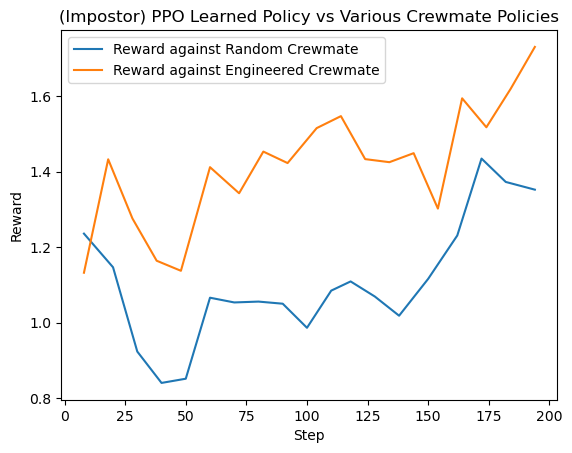

In [17]:
import matplotlib.pyplot as plt

# plot the impostor against random opponents
rx, ry= zip(*impostor_rewards_history[('random', 'random', 'random')])
gx, gy= zip(*impostor_rewards_history[('greedy', 'greedy', 'greedy')])
rx = [x / 10 for x in rx]
gx = [x / 10 for x in gx]

plt.plot(rx, ry, label='Reward against Random Crewmate')
plt.plot(gx, gy, label='Reward against Engineered Crewmate')
plt.title('(Impostor) PPO Learned Policy vs Various Crewmate Policies')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()
plt.show()

# Examine Performance of Crewmate Value Network

In [44]:
import matplotlib.pyplot as plt

others = []
s = []
a = []
r = []
d = []
true_v = []
pred_v = []

rt = []

for _ in range(3):
    others.append(player.RandomPlayer())
for _ in range(200):
    # play the game            
    s_t, a_t, r_t, d_t, v_t, _ = play(nn_player, False, others)
    s += s_t
    a += a_t
    r += r_t
    d += d_t
    true_v += v_t

    obsx, obst = network.obs_batch_to_tensor(s_t, device)
    pred_v_t = nn_player.crewmate_critic.forward(obsx, obst).detach().cpu().numpy()
    pred_v += list(pred_v_t)

    rt += [np.sum(r_t)]


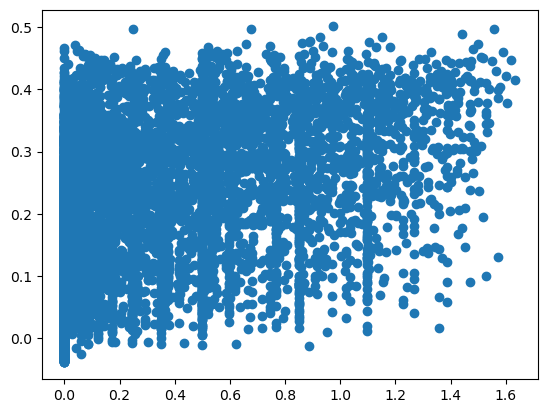

In [45]:
# plot the rewards
plt.scatter(true_v, pred_v)

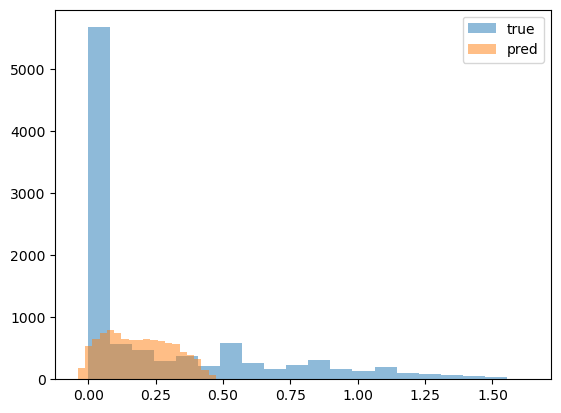

In [46]:
plt.hist(true_v, bins=20, alpha=0.5, label="true")
plt.hist(pred_v, bins=20, alpha=0.5, label="pred")
plt.legend(loc='upper right')

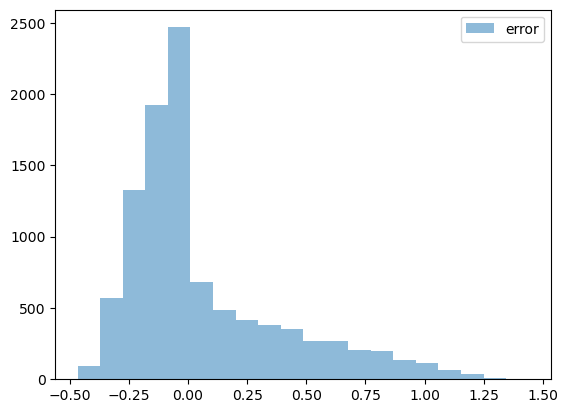

In [47]:
v_err = np.array(true_v) - np.array(pred_v)
plt.hist(v_err, bins=20, alpha=0.5, label="error")
plt.legend(loc='upper right')